In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math

from keras import backend as K
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense

from keras.layers import BatchNormalization

from keras.datasets import mnist
from keras.utils import np_utils
from tensorflow.keras.optimizers import SGD, RMSprop, Adam




np.random.seed(5)

In [ ]:
def generate_data(M, batch_size):
    input_ = [[0 for _ in range(pow(2, M))] for _ in range(M)]
    label = [[0 for _ in range(pow(2, M))] for _ in range(2 * M)]

    for i in range(1 << M):
        for j in range(M):
            if i & (1 << j):
                input_[M - j - 1][i] = 1

    for i in range(1 << M):
        for j in range(M):
            if input_[j][i] == 1:
                label[2 * j][i] = 1
                label[2 * j + 1][i] = 0
            else:
                label[2 * j][i] = 0
                label[2 * j + 1][i] = 1

    input_ = np.tile(np.array(input_), batch_size)
    label = np.tile(np.eye(1 << M), batch_size)

    return input_, label


def generate(M, N, batch_size):
    data, label = generate_data(M, batch_size)

    ran1 = np.random.permutation(batch_size * pow(2, M))  # Suffling Dataset
    ran2 = np.random.permutation(batch_size * pow(2, M))

    symbol1 = 2 * data[:, ran1] - 1
    symbol2 = 2 * data[:, ran2] - 1

    SPC = math.sqrt(0.8) * symbol1 + math.sqrt(0.2) * symbol2  # Superposition Coding

    label1 = np.transpose(label[:, ran1].astype('float32'))
    label2 = np.transpose(label[:, ran2].astype('float32'))

    return SPC, label1, label2


def generate_channel(N, M, k):
    h1 = np.random.randn(N, M) / math.sqrt(2)
    h2 = np.random.randn(N, M) / math.sqrt(2)

    if k == 0:
        return h1, h2
    else:
        return 2 * h1, 2 * h2


def generate_input(H1_real, H1_image, SPC, N, batch_size, sigma):
    N_real, N_image = generate_channel(N, batch_size * pow(2, N), 0)

    input1_real = np.matmul(H1_real, SPC) + sigma * N_real
    input1_img = np.matmul(H1_image, SPC) + sigma * N_image

    input1 = np.transpose(np.concatenate((input1_real, input1_img), axis=0))

    return input1



In [ ]:
#define the convnet
def model_cnn():
  model = Sequential()
  # CONV => RELU => POOL
  model.add(Conv2D(4, kernel_size=(2,2), padding="same"))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=1))
  # CONV => RELU => POOL
  model.add(Conv2D(8, kernel_size=(2,2), padding="same"))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=1))

  # Flatten => RELU layers
  model.add(Flatten())
  model.add(BatchNormalization(scale=True,center=True))
  model.add(Dense(200 * modulation_order,kernel_initializer=tf.initializers.truncated_normal(stddev=0.01)))
  model.add(Activation("relu"))

  # dense => RELU layers
  model.add(BatchNormalization(scale=True,center=True))
  model.add(Dense(200 * modulation_order,kernel_initializer=tf.initializers.truncated_normal(stddev=0.01)))
  model.add(Activation("relu"))

  # dense => RELU layers
  model.add(BatchNormalization(scale=True,center=True))
  model.add(Dense(200 * modulation_order,kernel_initializer=tf.initializers.truncated_normal(stddev=0.01)))
  model.add(Activation("relu"))

  # dense => RELU layers
  model.add(BatchNormalization(scale=True,center=True))
  model.add(Dense(200 * modulation_order,kernel_initializer=tf.initializers.truncated_normal(stddev=0.01)))
  model.add(Activation("relu"))

  #
  model.add(Dense(1 << M))
  model.add(BatchNormalization(scale=True,center=True))
  model.add(Activation("sigmoid"))
  return model


In [ ]:
def my_loss(y_t , y_p) :
    m_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_p, labels=y_t))
    return m_loss

def my_acc(y_t, y_p):
    print(y_t.shape)
    print(y_p.shape)
    #K.print_tensor(y_t)
    #K.print_tensor(y_p)
    correct_prediction = tf.equal(tf.argmax(y_p, axis= 1), tf.argmax(y_t, axis= 1))
    acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return acc

In [ ]:
# network and training
VERBOSE = "auto"
OPTIMIZER = Adam(epsilon= 1e-04)
VALIDATION_SPLIT=0.3
N = 8
M = 8
n_symbol = 1000
n_iteration = 1
NB_EPOCH = 1000
modulation_order = 2

SNR_db = np.array(list(range(0, 11, 2)))
# SNR_db = np.array(list(range(100,101)))
batch_size = 100
test_size = 1

ERROR_user1 = np.zeros([len(SNR_db), n_iteration])
ERROR_user2 = np.zeros([len(SNR_db), n_iteration])

The training block is responsible for producing the MIMO-NOMA signal and providing the labels to the DNN. In this block, to acquire the MIMO-NOMA signal for N antennas, we should produce **two training sequences of UE1 and UE2 for each antenna**. They are then modulated by superposition coding with different allocation power factors.
After impairment by the fading channel and AWGN channel

the receive signal is acquired at the receiver. Meanwhile, these sequences are known by the receiver as labels, and it is similar to the pilot sequence


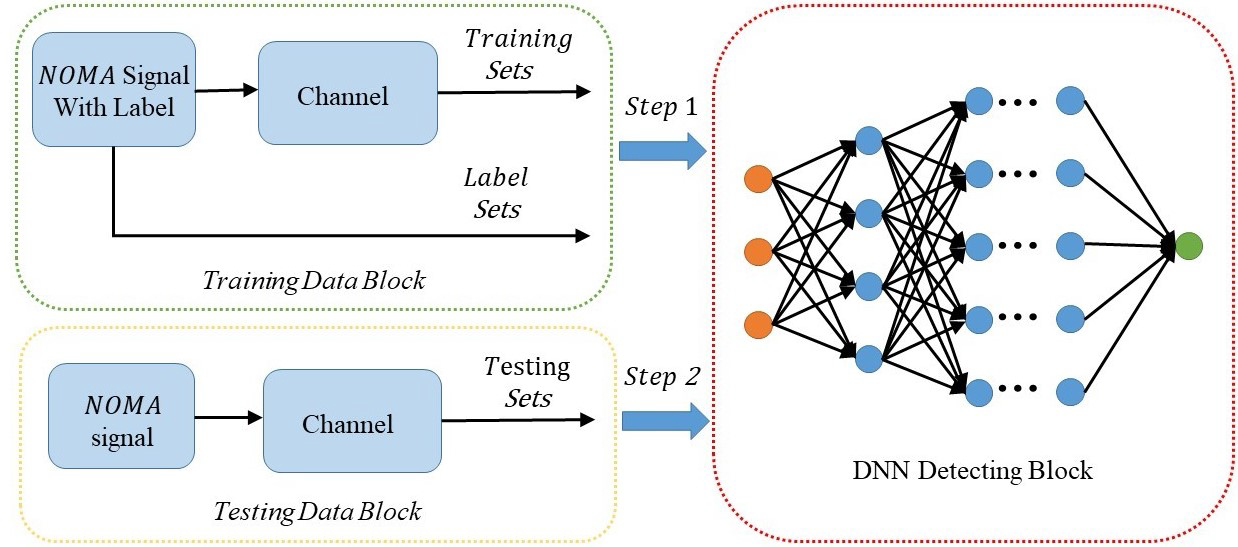

In [ ]:
for k in range(n_iteration):

    print('training iteration %d' % (k))

    H1_real, H1_image = generate_channel(N, M, 0)
    H2_real, H2_image = generate_channel(N, M, 1)

    for i in range(len(SNR_db)):

        print('User1 , SNR : {}'.format(SNR_db[i]))
        SPC, label1, _ = generate(M, N, batch_size)
        signal_power = np.mean(pow(SPC, 2))
        sigma_user1 = math.sqrt(signal_power / (math.sqrt(N) * pow(10, float(SNR_db[i]) / 10.0)))
        input1_train = generate_input(H1_real, H1_image, SPC, N, batch_size, sigma_user1)
        input1_train = tf.reshape(input1_train, [-1, 4, 4, 1])
        # initialize the optimizer and model
        model1 = model_cnn()
        model1.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,metrics=[my_acc])
        history1 = model1.fit(input1_train, label1, epochs=NB_EPOCH,verbose=VERBOSE ,validation_split=VALIDATION_SPLIT )


    for i in range(len(SNR_db)):
        print('User2 , SNR : {}'.format(SNR_db[i]))
        SPC, _, label2 = generate(M, N, batch_size)
        signal_power = np.mean(pow(SPC, 2))
        sigma_user2 = math.sqrt(signal_power / (math.sqrt(N) * pow(10, float(SNR_db[i]) / 10.0)))
        input2_train = generate_input(H2_real, H2_image, SPC, N, batch_size, sigma_user2)
        input2_train = tf.reshape(input2_train, [-1, 4, 4, 1])

        # initialize the optimizer and model
        model2 = model_cnn()
        model2.compile(loss= "categorical_crossentropy" , optimizer=OPTIMIZER,metrics= [my_acc] )
        history2 = model2.fit(input2_train, label2, epochs=NB_EPOCH,verbose=VERBOSE ,validation_split=VALIDATION_SPLIT )




training iteration 0
User1 , SNR : 0
Epoch 1/1000
(32, 256)
(32, 256)
(32, 256)
(32, 256)
558/560 [============================>.] - ETA: 0s - loss: 3.6782 - my_acc: 0.1796(32, 256)
(32, 256)
560/560 [==============================] - 17s 10ms/step - loss: 3.6763 - my_acc: 0.1797 - val_loss: 2.5792 - val_my_acc: 0.3556
Epoch 2/1000
560/560 [==============================] - 5s 10ms/step - loss: 2.8532 - my_acc: 0.2950 - val_loss: 2.0236 - val_my_acc: 0.4309
Epoch 3/1000
560/560 [==============================] - 5s 10ms/step - loss: 2.5469 - my_acc: 0.3439 - val_loss: 1.8750 - val_my_acc: 0.4608
Epoch 4/1000
560/560 [==============================] - 5s 9ms/step - loss: 2.3366 - my_acc: 0.3795 - val_loss: 1.6305 - val_my_acc: 0.5216
Epoch 5/1000
560/560 [==============================] - 5s 8ms/step - loss: 2.1968 - my_acc: 0.4065 - val_loss: 1.7118 - val_my_acc: 0.5133
Epoch 6/1000
560/560 [==============================] - 5s 10ms/step - loss: 2.0493 - my_acc: 0.4410 - val_loss: 1.66

The testing block is used to simulate real-time MIMO-NOMA transmission.
 In this block, we first produce the MIMO-NOMA signal.Labels are not required in this part.

The testing data are used to assess the performance of the DNN detection. Notably, in order to avoid a perfect match, the channel models and the generated data in training blocks and testing block are i.i.d. to ensure that the DNN performs well in both the training and testing process.

The SNR in training block is generated randomly with the data time slot varying over the range of interest, whereas the SNR in the testing block is fixed so that the error performance of the DNN can be evaluated in certain SNR conditions.

In [ ]:
for k in range(n_iteration):

  print('testing operation %d' % (k))
  for i in range(len(SNR_db)):
      SPC_test, test_label1, test_label2 = generate(M, N, batch_size * test_size)
      signal_power = np.mean(pow(SPC, 2))
      sigma = math.sqrt(signal_power / (math.sqrt(N) * pow(10, float(SNR_db[i]) / 10.0)))

      input1_test = generate_input(H1_real, H1_image, SPC_test, N, batch_size * test_size, sigma)
      input1_test = tf.reshape(input1_test, [-1, 4, 4, 1])
      score1 = model1.evaluate(input1_test,test_label1, verbose=VERBOSE)
      ERROR_user1[i, k] = 1 - score1[1]

      input2_test = generate_input(H2_real, H2_image, SPC_test, N, batch_size * test_size, sigma)
      input2_test = tf.reshape(input2_test, [-1, 4, 4, 1])
      score2 = model2.evaluate(input2_test,test_label2, verbose=VERBOSE)
      ERROR_user2[i, k] = 1 - score2[1]

error1 = np.mean((ERROR_user1), axis=1)
error2 = np.mean((ERROR_user2), axis=1)

In [ ]:
#print(H1_real)
plt.figure()
plt.semilogy(SNR_db, error1, ls='--', marker='o', label='user1')
plt.semilogy(SNR_db, error2, ls='--', marker='+', label='user2')
plt.grid()
plt.legend()
plt.ylim(pow(10, -6), pow(10, 0))
plt.xlabel('SNR')
plt.ylabel('SER')
plt.title('SER of user2 in 4X4 MIMO_NOMA BPSK_DNN')
plt.savefig('SER_44MIMO_NOMA_DNN_BPSK')
plt.show()

print(error1)
print(error2)

In [ ]:
# list all data in history
# summarize history for accuracy
plt.figure()
plt.plot(history1.history['my_acc'])
plt.plot(history1.history['val_my_acc'])
plt.title('model-1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train UE1', 'test UE1'], loc='upper right')
plt.show()
# summarize history for loss
plt.figure()
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train UE1', 'test UE1'], loc='upper right')
plt.show()

In [ ]:
# list all data in history
# summarize history for accuracy
plt.figure()
plt.plot(history2.history['my_acc'])
plt.plot(history2.history['val_my_acc'])
plt.title('model-2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# summarize history for loss
plt.figure()
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model-2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train UE2', 'test UE2'], loc='upper right')
plt.show()